# Bryce Hill | ECEN 4562

## Lab 8: Amplitude Modulation and Complex Lowpass Signals


### 4/11/17

In [1]:
# Import libraries
from pylab import *         # Imports numpy (as np) and matplotlib (as mpl)
import numpy as np
import scipy.integrate as integrate
%matplotlib notebook 
                            # Adds interactive matplotlib backend
plt.rc('text', usetex=True) # Enable the use of LaTeX for plot titles/labels

# Import my libraries
import my_grc
import my_sdr as sdr
import my_jupyter
import my_ft as ft
import my_ascbin as ascbin
import my_am as am

** <span style="color:red"> NOTE: must run *install_bryce_lib.sh* file to install libraries onto your computer. When done simply run the *uninstall_bryce_lib.sh* script </span>. **

In [2]:
print(my_grc.testmy_grc())
my_jupyter.my_settings()

Package gnuradiopkg imported correctly
Plot settings imported into current workspace


In [3]:
# matplotlib.pyplot.tight_layout()

## Experiment 1:  AM Transmitter/Receiver

### ----------------------------------------------------------------------------------------------------------------
 
 - ** 1.a - FIR LPF/BPF with Trapezoidal H(f). **

### ----------------------------------------------------------------------------------------------------------------

f1:  4000.0 | f2:  16000.0  | llim:  0.001


<IPython.core.display.Javascript object>


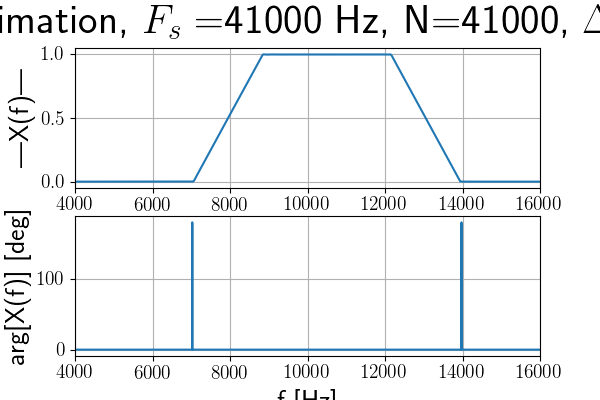

In [44]:
Fs = 41000      # Sampling Frequency
fBW = 5100      # Bandwidth Frequency
fc = 10500       # Center Frequency
alpha = .35001  # Rolloff Parameter
k = 100          # Truncation Parameter
# sig = [0]*Fs
# sig[int(Fs/2)] = Fs

tlen = 1;
tt = arange(round(tlen*Fs))/float(Fs) - tlen/2.0
ix = argmin(abs(tt-0))
dt = zeros(len(tt))
dt[ix] = Fs

sig_w = sdr.sigWave(dt, Fs, tt[0])
[sig_w, order]= sdr.trapfilt(sig_w, [fBW, fc], k, alpha, 0, 0)
ft.showft(sig_w, [4000, 16000, 1e-3], 1)

I cranked k way up to make the edges as sharp as they are in the handout and to get rid of the phase spikes. Can't quite get rid of the spikes but it does seem to match well. 

### --------------------------------------------------------------------------------------------------------------
 
 - ** 1.b - AM Transmitter**

### --------------------------------------------------------------------------------------------------------------

In [5]:
Fs = 44100 # Sampling rate
tlen = 1.0 # Duration
f0, f1 = 3000, 5000  #  Message frequencies
tt = arange(round(tlen*Fs))/float(Fs)   # Time axis
mt = cos(2*pi*f0*tt) + cos(2*pi*f1*tt)  # Message signal
sig_mt = sdr.sigWave(mt, Fs, 0)        # Waveform from class sigWave

<IPython.core.display.Javascript object>


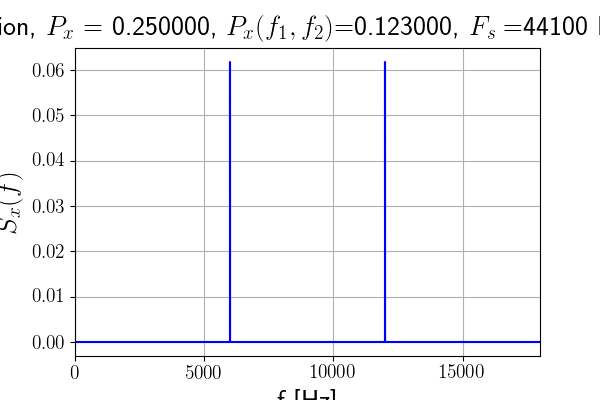

In [6]:
fcparms = [9000, 0, .05]
fmparms = [4000, 10, .05]
fBparms = []
sig_xt = am.amxmtr(sig_mt, 'sc', fcparms, fmparms, fBparms)
window = 18000
ft.showpsd0(sig_xt, [0, window, 0], Fs)

Now, investigate the change by changing to a transmitted carrier and an alfa = .7

<IPython.core.display.Javascript object>


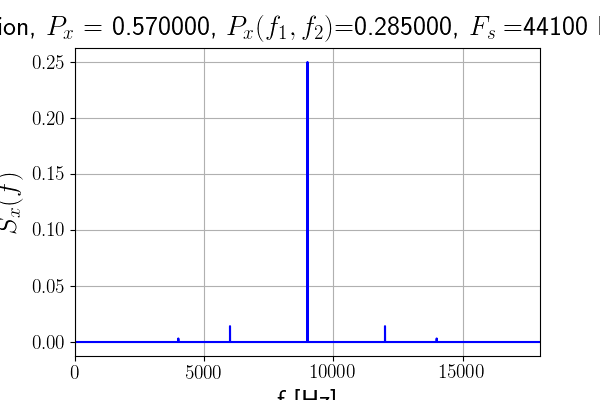

In [7]:
fmparms[2] = .7
sig_xt = am.amxmtr(sig_mt, 'tc', fcparms, fmparms, fBparms)
window = 18000
ft.showpsd0(sig_xt, [0, window, 0], Fs)

The peaks at the amplitudes of the message frequency are reduced, though still visible. Also, there is now a peak at the new transmitted carrier frequency which is exactly as we would expect

### --------------------------------------------------------------------------------------------------------------
 
 - ** 1.c - Speech signal investigation **

### --------------------------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>


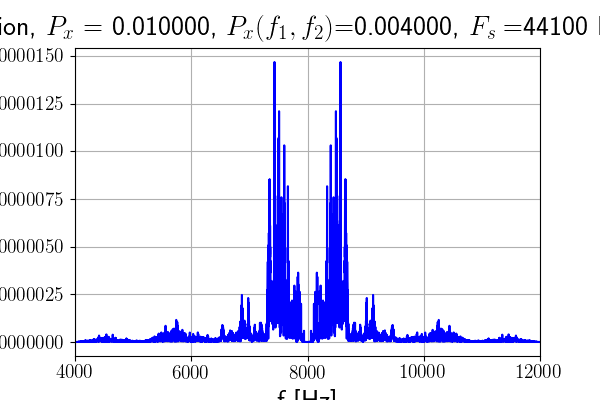

<IPython.core.display.Javascript object>


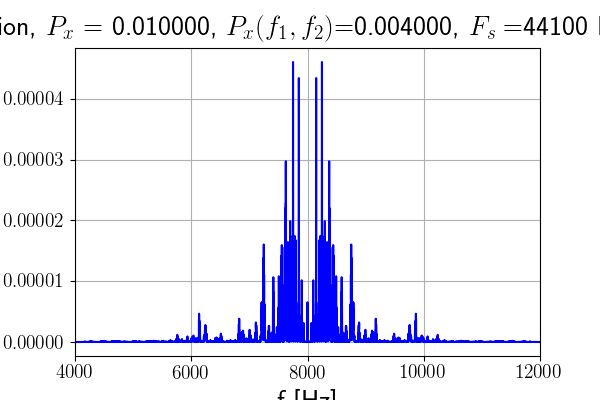

In [8]:
Fs = 44100 # Sampling rate
[sig_mtw_c1, Fs1] = sdr.wavread('speech801.wav')
sig_mt_c1 = sdr.sigWave(sig_mtw_c1, Fs1, 0)
[sig_mtw_c2, Fs2] = sdr.wavread('music801.wav')
sig_mt_c2 = sdr.sigWave(sig_mtw_c2, Fs2, 0)

fcparms = [8000, -90, .05]
fmparms = [4000, 10, .05]
fBparms = []
# Ac1 = 1
# Ac2 = .75

sig_xt_c1 = am.amxmtr(sig_mt_c1, 'sc', fcparms, fmparms, fBparms)
sig_xt_c2 = am.amxmtr(sig_mt_c2, 'sc', fcparms, fmparms, fBparms)

sig_xt_c2.sig = .75*sig_xt_c2.sig


window = 12000
ft.showpsd0(sig_xt_c1, [4000, window, 0], Fs1)

window = 12000
ft.showpsd0(sig_xt_c2, [4000, window, 0], Fs2)

When the amplitude of the second signal is adjusted to .75 the total power in the PSDs match

In [9]:
# Write the waves to a file for later use
sdr.wavwrite(sig_xt_c1.sig, Fs1, 'myam801.wav')
sdr.wavwrite(sig_xt_c2.sig, Fs2, 'myam802.wav')

Fs3 = Fs1
sig_xt_c3 = (sig_xt_c1.sig + sig_xt_c2.sig)/sqrt(2.0)
sdr.wavwrite(sig_xt_c3, Fs3, 'myam803.wav')

<IPython.core.display.Javascript object>


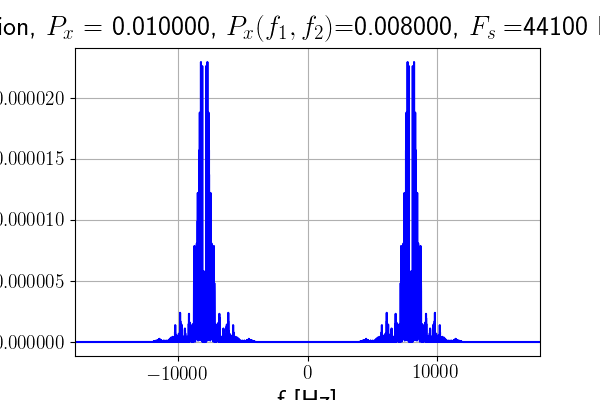

In [10]:
sig_xt_c3 = sdr.sigWave(sig_xt_c3, Fs3, 0)
window = 18000
ft.showpsd0(sig_xt_c3, [-window, window, 0], Fs3)

The bandwidth does not appear to change for the 3rd signal

<IPython.core.display.Javascript object>


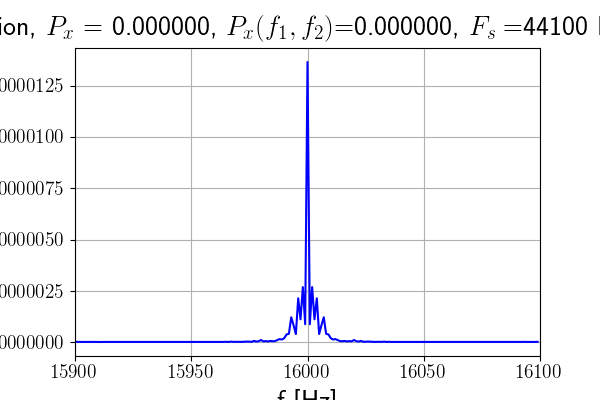

<IPython.core.display.Javascript object>


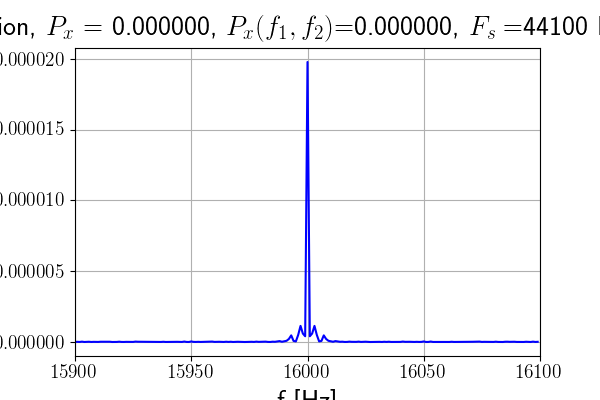

In [11]:
# Square x1 and x2 and look at PSD
sig_xt2_c1 = sdr.sigWave(np.square(sig_xt_c1.sig), Fs1, 0)
sig_xt2_c2 = sdr.sigWave(np.square(sig_xt_c2.sig), Fs2, 0)

ft.showpsd0(sig_xt2_c1, [15900, 16100, 0], Fs1)

ft.showpsd0(sig_xt2_c2, [15900, 16100, 0], Fs2)

Useful information from x1 and x2 squared:

### --------------------------------------------------------------------------------------------------------------
 
 - ** 1.d - AM Reciever in Python **

### --------------------------------------------------------------------------------------------------------------

In [12]:
[sig_my1, Fs1] = sdr.wavread('myam801.wav')
sig_my1w = sdr.sigWave(sig_my1, Fs1, 0)
[sig_my2, Fs2] = sdr.wavread('myam802.wav')
sig_my2w = sdr.sigWave(sig_my2, Fs2, 0)
[sig_my3, Fs3] = sdr.wavread('myam803.wav')
sig_my3w = sdr.sigWave(sig_my3, Fs3, 0)

sig_my1_f = am.amrcvr(sig_my1w, 'coh', fcparms, fmparms, fBparms, True)
sig_my2_f = am.amrcvr(sig_my2w, 'coh', fcparms, fmparms, fBparms, True)
sig_my3_f = am.amrcvr(sig_my3w, 'coh', fcparms, fmparms, fBparms, True)

sdr.wavwrite(sig_my1_f.sig, Fs1, 'myam801_rcvd.wav')
sdr.wavwrite(sig_my2_f.sig, Fs2, 'myam802_rcvd.wav')
sdr.wavwrite(sig_my3_f.sig, Fs1, 'myam803_rcvd.wav')

The signals were recovered! Listen to the .wav files

### --------------------------------------------------------------------------------------------------------------
 
 - ** 1.e - AM Signal Demodulation **

### --------------------------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>


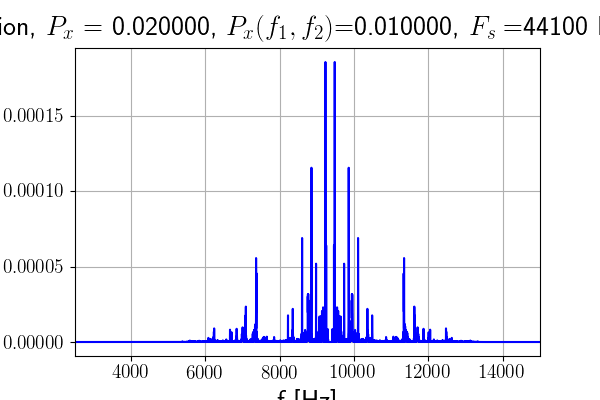

<IPython.core.display.Javascript object>


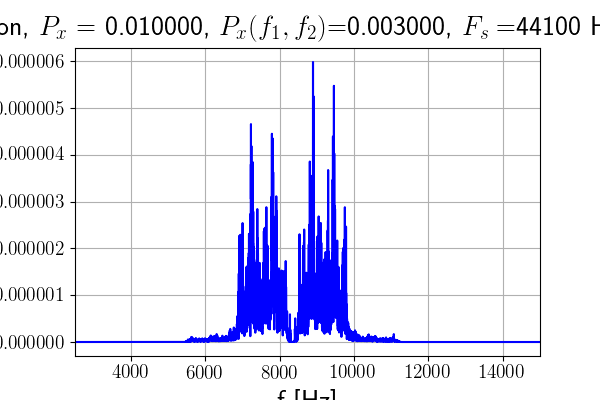

<IPython.core.display.Javascript object>


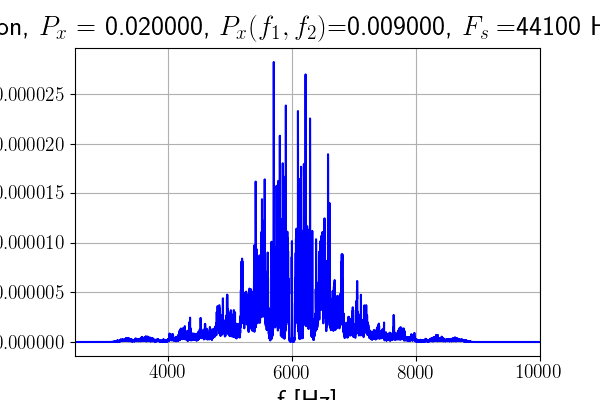

<IPython.core.display.Javascript object>


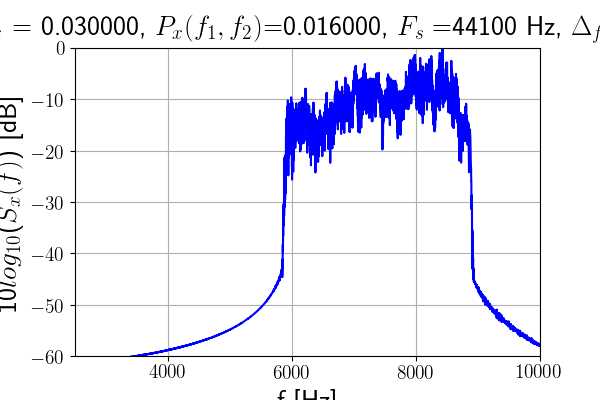

In [13]:
# Look at PSD of the unmodulated signals
[sig_mtw_e1, Fs1] = sdr.wavread('amsig801.wav')
sig_mt_e1 = sdr.sigWave(sig_mtw_e1, Fs1, 0)
[sig_mtw_e2, Fs2] = sdr.wavread('amsig802.wav')
sig_mt_e2 = sdr.sigWave(sig_mtw_e2, Fs2, 0)
[sig_mtw_e3, Fs3] = sdr.wavread('amsig803.wav')
sig_mt_e3 = sdr.sigWave(sig_mtw_e3, Fs3, 0)
[sig_mtw_e4, Fs4] = sdr.wavread('amsig804.wav')
sig_mt_e4 = sdr.sigWave(sig_mtw_e4, Fs4, 0)

window = 15000
ft.showpsd0(sig_mt_e1, [2500, window, 0], Fs1)
window = 15000
ft.showpsd0(sig_mt_e2, [2500, window, 0], Fs2)
window = 10000
ft.showpsd0(sig_mt_e3, [2500, window, 0], Fs3)
# Speech typically has a 3khz bandwidth
window = 10000
ft.showpsd0(sig_mt_e4, [2500, window, -60], Fs4)

In [14]:
# # amsig801 demodulation
fcparms = [9357, -90]
fmparms = [(13350-9357), 10, .4]
fBparms = []

sig_xt_e2 = am.amrcvr(sig_mt_e1,'coh', fcparms, fmparms, fBparms, True)
sdr.wavwrite(sig_xt_e2.sig, Fs1, 'myamsig801.wav')

# amsig802 demodulation There is an unstable carrier here
fcparms = [8350, -90]
fmparms = [11384-8360, 10, .4]
fBparms = [3000, 11350-8350, 10, .4]

sig_xt_e2 = am.amrcvr(sig_mt_e2,'coh', fcparms, fmparms, fBparms, True)
sdr.wavwrite(sig_xt_e2.sig, Fs2, 'myamsig802.wav')
# Due to the unstable carrier, bandpass filter to remove lower lobe

# amsig803 demodulation
fcparms = [5998.5, 10]
fmparms = [9000-5998.5, 10, .05]
# fBparms = [3000, 7500, 10, .05]
# fBparms = []

sig_xt_e3 = am.amrcvr(sig_mt_e3,'coh', fcparms, fmparms, fBparms, False)
# ft.showpsd0(sig_xt_e3, [0, 15000, -60], Fs3)
sdr.wavwrite(sig_xt_e3.sig, Fs3, 'myamsig803.wav')
# Two distinct signals here but I can't seem to isolate either

# amsig804 demodulation
fcparms = [8950, -90]
fmparms = [3000, 10, .05]
fBparms = []

sig_xt_e4 = am.amrcvr(sig_mt_e4,'coh', fcparms, fmparms, fBparms, False)
sdr.wavwrite(sig_xt_e4.sig, Fs4, 'myamsig804.wav')

These signals were also recovered well

### --------------------------------------------------------------------------------------------------------------
 
 - ** 1.f -  AM Signal Demodulation Continued **

### --------------------------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>


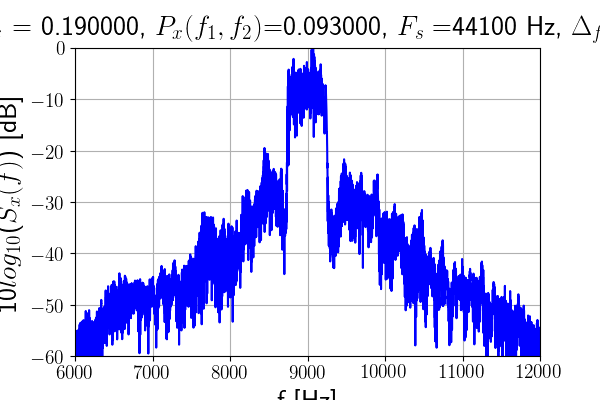

<IPython.core.display.Javascript object>


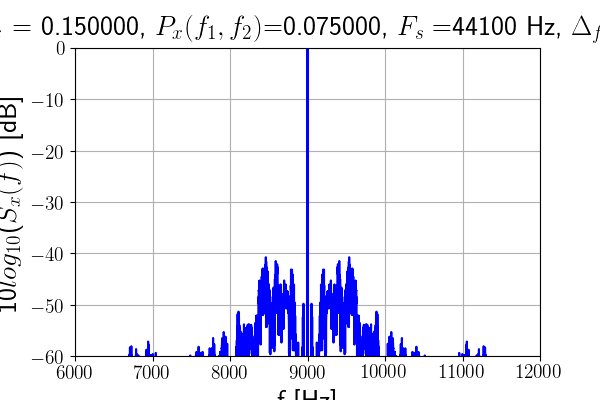

<IPython.core.display.Javascript object>


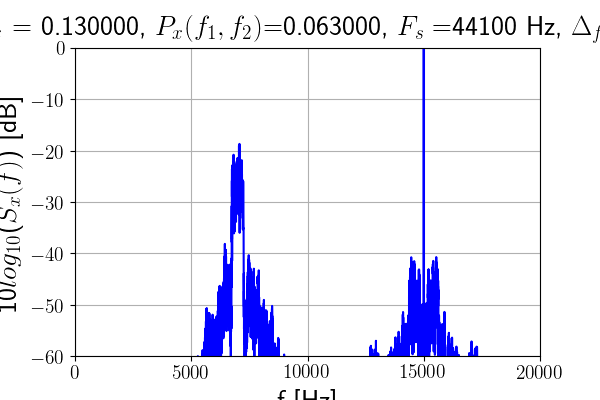

In [15]:
# Look at PSD of the unmodulated signals
[sig_mtw_e5, Fs5] = sdr.wavread('amsig805.wav')
sig_mt_e5 = sdr.sigWave(sig_mtw_e5, Fs5, 0)
[sig_mtw_e6, Fs6] = sdr.wavread('amsig806.wav')
sig_mt_e6 = sdr.sigWave(sig_mtw_e6, Fs6, 0)
[sig_mtw_e7, Fs7] = sdr.wavread('amsig807.wav')
sig_mt_e7 = sdr.sigWave(sig_mtw_e7, Fs7, 0)

ft.showpsd0(sig_mt_e5, [6000, 12000, -60], Fs5)
# Can see that the main central pulse is the carrier and it has been moving around
ft.showpsd0(sig_mt_e6, [6000, 12000, -60], Fs6)
ft.showpsd0(sig_mt_e7, [0, 20000, -60], Fs7)

In [16]:
# amsig805 demodulation
fcparms = [9000, -90]
fmparms = [(12000-9000), 10, .05]
fBparms = []

sig_xt_e5 = am.amrcvr(sig_mt_e5,'abs', fcparms, fmparms, fBparms, True)
sdr.wavwrite(sig_xt_e5.sig, Fs5, 'myamsig805.wav')
# high pitch whine is due to moving carrier frequency

# amsig806 demodulation
fcparms = [9000, -90]
fmparms = [10560-9000, 10, .4]
fBparms = []

sig_xt_e6 = am.amrcvr(sig_mt_e6,'abs', fcparms, fmparms, fBparms, True)
sdr.wavwrite(sig_xt_e6.sig, Fs6, 'myamsig806.wav')

# amsig807 demodulation of low frequency
fcparms = [7000, -90]
fmparms = [9000-7000, 10, .05]
fBparms = [6000, 7000, 10, .05]

sig_xt_e7 = am.amrcvr(sig_mt_e7,'abs', fcparms, fmparms, fBparms, True)
sdr.wavwrite(sig_xt_e7.sig, Fs7, 'myamsig807_1.wav')

# amsig807 demodulation
fcparms = [15000, -90]
fmparms = [16500-15000, 10, .05]
fBparms = [4600, 15000, 10, .05]

sig_xt_e7 = am.amrcvr(sig_mt_e7,'abs', fcparms, fmparms, fBparms, True)
sdr.wavwrite(sig_xt_e7.sig, Fs7, 'myamsig807_2.wav')

Amsig807 contains both signals from 805 and 806

### --------------------------------------------------------------------------------------------------------------
 
 - ** 1.g - Real-valued AM demodulator for AM-DSB-SC signals in GNU Radio.  **

### --------------------------------------------------------------------------------------------------------------

There is not much tuning you can do with just the real part of the signal available. Even when looking at the square of the input signal as shown in the lowest frequency chart and using that information to fine tune to, the signal just doesn't get cleaner. In experiment 2 it is possible to get a better reception using complex signal processing.

## Experiment 2: QAM Transmitter/Receiver 

### ----------------------------------------------------------------------------------------------------------------
 
 - ** 2.a FIR LPF/BPF with Complex-Valued Filter Coefficients **

### ----------------------------------------------------------------------------------------------------------------

<IPython.core.display.Javascript object>


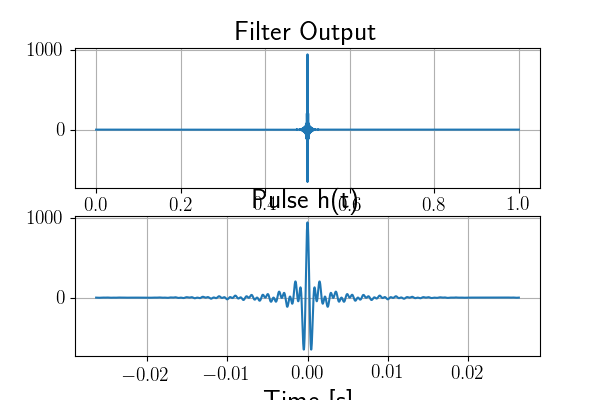

f1:  -2000.0 | f2:  3000.0  | llim:  0.001


/home/bryce/.local/lib/python3.4/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


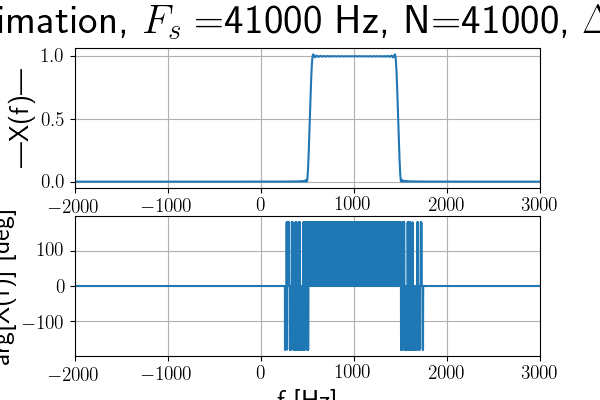

In [23]:
Fs = 41000      # Sampling Frequency
fBW = 950      # Bandwidth Frequency
fc = 1000       # Center Frequency
alpha = .05001  # Rolloff Parameter
k = 50          # Truncation Parameter

tlen = 1;
tt = arange(round(tlen*Fs))/float(Fs) - tlen/2.0
ix = argmin(abs(tt-0))
dt = zeros(len(tt))
dt[ix] = Fs

# dt = [0]*Fs
# dt[int(Fs/2)] = Fs

dt_w = sdr.sigWave(dt, Fs, 0)
[dt_w, order]= sdr.trapfilt_cc(dt_w, [fBW, fc], k, alpha, 1, 0)
ft.showft(dt_w, [-2000, 3000, 1e-3], 1)

### --------------------------------------------------------------------------------------------------------------
 
 - ** 2.b Complex-Valued QAM Modulator.  **

### --------------------------------------------------------------------------------------------------------------

Create myam803 QAM signal using the QAM transmitter

In [18]:
[sig_803_rcvd, Fs] = sdr.wavread('myam803_rcvd.wav')
sig_803_rcvd = sdr.sigWave(sig_803_rcvd, Fs, 0)
myam803 = am.qamxmtr(sig_803_rcvd, [8000, 0, 0], [4000, 10, .05])
sdr.wavwrite(myam803.sig, Fs, 'myam803qam.wav')

Now, generate a complex valued low-pass signal from the speech801.wav file

In [19]:
[sig_801, Fs] = sdr.wavread('speech801.wav')
sig_801 = sdr.sigWave(sig_801, Fs, 0)
myam803 = am.qamxmtr(sig_801, [8000, 0, 0], [4000, 10, .05])
sdr.wavwrite(myam803.sig, Fs, 'myam801ssb.wav')

### --------------------------------------------------------------------------------------------------------------
 
 - ** 2.c Complex-Valued QAM Receiver.  **

### --------------------------------------------------------------------------------------------------------------

In [20]:
# myamsig803qam demodulation
fcparms = [8000, 0, 0]
fmparms = [4000, 10, .05]

[sig_803qam, Fs] = sdr.wavread('myam803qam.wav')
sig_803qam = sdr.sigWave(sig_803qam, Fs, 0)
sig_xt_803qam = am.qamrcvr(sig_803qam, fcparms, fmparms)
sdr.wavwrite(sig_xt_803qam.sig, Fs6, 'myam803qam_rcvd.wav')

/home/bryce/Documents/Class/CommLab/my_library/my_sdr/my_sdr/wavfun.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  dn = around(dn*2**15).astype(dtype='int16')


### --------------------------------------------------------------------------------------------------------------
 
 - ** 2.d Revaluate Signals from E1 with QAM Now **

### --------------------------------------------------------------------------------------------------------------

In [21]:
# myam801ssb demodulation
fcparms = [8000, 0, 0]
fmparms = [4000, 10, .05]

[sig_801ssb, Fs] = sdr.wavread('myam801ssb.wav')
sig_801ssb = sdr.sigWave(sig_801ssb, Fs, 0)
sig_xt_801ssb = am.qamrcvr(sig_801ssb, fcparms, fmparms)
sdr.wavwrite(sig_xt_801ssb.sig, Fs, 'myam801ssb_rcvd.wav')

/home/bryce/Documents/Class/CommLab/my_library/my_sdr/my_sdr/wavfun.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  dn = around(dn*2**15).astype(dtype='int16')


Now, test the QAM reciever with the E1.c signals:

In [22]:
# amsig805 demodulation
fcparms = [9000, 0, 0]
fmparms = [(12000-9000), 10, .05]
# fBparms = []

sig_xt_e5 = am.qamrcvr(sig_mt_e5, fcparms, fmparms)
sdr.wavwrite(sig_xt_e5.sig, Fs5, 'myamsig805_QAMrcvd.wav')

# amsig806 demodulation
fcparms = [9000, 0, 0]
fmparms = [10560-9000, 10, .4]
# fBparms = []
sig_xt_e6 = am.qamrcvr(sig_mt_e6, fcparms, fmparms)
sdr.wavwrite(sig_xt_e6.sig, Fs6, 'myamsig806_QAMrcvd.wav')

# amsig807 demodulation of low frequency
fcparms = [7000, 0, 0]
fmparms = [9000-7000, 10, .05]
# fBparms = [6000, 7000, 10, .05]
sig_xt_e7 = am.qamrcvr(sig_mt_e7, fcparms, fmparms)
sdr.wavwrite(sig_xt_e7.sig, Fs7, 'myamsig807_QAMrcvd_1.wav')

# amsig807 demodulation
fcparms = [15000, 0, 0]
fmparms = [16500-15000, 10, .05]
# fBparms = [4600, 15000, 10, .05]
sig_xt_e7 = am.qamrcvr(sig_mt_e7, fcparms, fmparms)
sdr.wavwrite(sig_xt_e7.sig, Fs7, 'myamsig807_QAMrcvd_2.wav')

/home/bryce/Documents/Class/CommLab/my_library/my_sdr/my_sdr/wavfun.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  dn = around(dn*2**15).astype(dtype='int16')


### --------------------------------------------------------------------------------------------------------------
 
 - ** 2.e Complex-valued AM demodulator for AM-DSB-SC signals in GNU Radio.
 **

### --------------------------------------------------------------------------------------------------------------

The best I could do was to get station 2 to be nice and steady with about about a .06 Hz fading in and out. I did this by looking at the square of the original signal as shown in the bottom frequency display

![title](img/e2_e_0.png)

### --------------------------------------------------------------------------------------------------------------
 
 - ** 2.f GNU Radio AM-DSB vs. QAM.
 **

### --------------------------------------------------------------------------------------------------------------

First, I have to select a decimation factor. It needs to evenly divide the 240kHz signal frequency. I selected:

In [27]:
decimationFactor = 240000/48000
print(decimationFactor)

5.0


The 48 kHz is a little high for a speech signal, 8 or 15 could have worked as well

Next, I look at the raw frequency content of the signal before any processing to look for frequency locations. Note that I added an average of 10 to clean it up

![title](img/e2_f.png)

I can see from this that approximate carrier locations are:
- 23 kHz
- 38 kHz
- 50 kHz
- 70 kHz
- 75 kHz (These look like they have a lot of interchanel interference?)
- 96 kHz


This one seems like I should have been able to get it cleaner but there is a lot of noise and a high pitch warble in the background. 

![title](img/e2_f_23khz.png)

#------------------------------------------------------------------------------------------------

The third carrier of ~50 kHz holds two signals. A country song and a talk show broadcast. It seems impossible to adjust phase such that only one signal is being heard. I think that might require additions to the gnu-radio flowgraph. Either way, the following figure shows the best demodulation I was able to achieve

![title](img/e2_f_50khz.png)

#------------------------------------------------------------------------------------------------

I found a fairly good "you can go your own way" song playing at 70 kHz. However, over time, slowly, it will drift in and out and the phase that I show in the next picture isn't good anymore. 

![title](img/e2_f_70khz.png)

#------------------------------------------------------------------------------------------------

The signal at 75khz is very hard to demodulate and suffers from extreme inter channel interference from the 70 khz signal. I tried lowering my LPF bandwidth. Lowering from 10 kHz to 5 kHz helped reduce the interfernce some but also starts attenuating the signal I am trying to listen to as well.

![title](img/e2_f_75khz.png)

#------------------------------------------------------------------------------------------------

This one came out much better. There is still a fair amount of background noise. But the signal is fairly clean otherwise

![title](img/e2_f_95khz.png)